This notebook show the stats & properties of original graph from `huggingface_bge.pt` 

In [13]:
import torch
from torch_geometric.data import Data

dataset_path='./task_classification/data/huggingface_bge.pt'
data = torch.load(dataset_path)

In [28]:
import json

# The name of the input file
input_filename = './task_classification/data/task_to_id.txt'
# The name of the output JSON file
output_filename = './task_classification/data/task_to_id.json'

# Create an empty dictionary to store the data
data_dict = {}

try:
    # Open and read the input file
    with open(input_filename, 'r') as f:
        # Loop through each line in the file
        for line in f:
            # Skip any blank lines
            if not line.strip():
                continue
            
            # Split the line by the tab character into a key and a value
            key, value = line.strip().split('\t')
            
            # Add the entry to the dictionary, converting the value to an integer
            data_dict[key] = int(value)

    # Convert the Python dictionary to a JSON formatted string
    json_output = json.dumps(data_dict, indent=4)

    # Save the JSON output to a new file
    with open(output_filename, 'w') as f:
        f.write(json_output)

    print(f"✅ Successfully converted '{input_filename}' to '{output_filename}'!")

except FileNotFoundError:
    print(f"❌ Error: The file '{input_filename}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

✅ Successfully converted '../task_classification/data/task_to_id.txt' to 'task_to_id.json'!


In [14]:
def fix2graph(data):
    # 1. First, perform the conversion on the edge_index and store it in a new variable
    corrected_edge_index = torch.stack(list(data.edge_index), dim=0).long()
    
    # 2. Now, create a new PyG Data object using the components from your original object
    #    and the newly corrected edge_index.
    new_data = Data(
        x=data.x,
        edge_index=corrected_edge_index,
        y=data.y,
        train_mask=data.train_mask,
        val_mask=data.val_mask,
        test_mask=data.test_mask
    )
    
    # 3. (Optional but recommended) Verify the new object
    print("--- New PyG Data Object ---")
    print(new_data)
    print("\n--- Checking the new edge_index ---")
    print(new_data.edge_index) 
    # This should now show a single tensor of shape [2, N]
    return new_data

In [15]:
data = fix2graph(data)

--- New PyG Data Object ---
Data(x=[152435, 768], edge_index=[2, 166199], y=[152435, 52], train_mask=[152435], val_mask=[152435], test_mask=[152435])

--- Checking the new edge_index ---
tensor([[  8971,   8971,   8971,  ...,  39460,  57835,   2206],
        [ 97862,  11921, 148534,  ...,  92090,  92090,  92090]])


In [16]:
print("Validation label density:", data.y[data.val_mask].float().mean().item())
print("Test label density:    ", data.y[data.test_mask].float().mean().item())

Validation label density: 0.020585330203175545
Test label density:     0.020171033218503


In [17]:
data.y[data.val_mask].float()

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [18]:
# =============================================================================
# EDA: Label Distribution Analysis
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter
import networkx as nx
from torch_geometric.utils import to_networkx
import json
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🔍 Starting EDA Analysis...")
print(f"Graph info: {data.num_nodes} nodes, {data.num_edges} edges")
print(f"Feature dimension: {data.x.shape[1]}")
print(f"Number of labels: {data.y.shape[1]}")
print(f"Device: {data.x.device}")

# Load task to index mapping
print("\n📋 Loading task label mappings...")
try:
    with open('experiment_runs/run_2025-10-02_14-47-01/task_to_idx.json', 'r') as f:
        task_to_idx = json.load(f)
    idx_to_task = {v: k for k, v in task_to_idx.items()}
    print(f"✅ Loaded {len(task_to_idx)} task labels")
    print(f"Sample mappings: {dict(list(task_to_idx.items())[:5])}")
except FileNotFoundError:
    print("⚠️ task_to_idx.json not found, using numeric indices")
    task_to_idx = {}
    idx_to_task = {}


🔍 Starting EDA Analysis...
Graph info: 152435 nodes, 166199 edges
Feature dimension: 768
Number of labels: 52
Device: cpu

📋 Loading task label mappings...
✅ Loaded 54 task labels
Sample mappings: {'text-generation': 0, 'question-answering': 1, 'text-to-video': 2, 'image-to-video': 3, 'image-to-3d': 4}


In [19]:
# 1. Label Distribution Analysis
print("=" * 60)
print("📊 LABEL DISTRIBUTION ANALYSIS")
print("=" * 60)

# Convert labels to numpy for analysis
labels = data.y.cpu().numpy()
train_labels = data.y[data.train_mask].cpu().numpy()
val_labels = data.y[data.val_mask].cpu().numpy()
test_labels = data.y[data.test_mask].cpu().numpy()

# Calculate label statistics
total_labels = labels.sum(axis=0)
train_label_counts = train_labels.sum(axis=0)
val_label_counts = val_labels.sum(axis=0)
test_label_counts = test_labels.sum(axis=0)

# Create label distribution dataframe
label_df = pd.DataFrame({
    'Label_Index': range(len(total_labels)),
    'Total_Count': total_labels,
    'Train_Count': train_label_counts,
    'Val_Count': val_label_counts,
    'Test_Count': test_label_counts
})

# Calculate percentages
label_df['Total_Percentage'] = (label_df['Total_Count'] / label_df['Total_Count'].sum()) * 100
label_df['Train_Percentage'] = (label_df['Train_Count'] / label_df['Train_Count'].sum()) * 100
label_df['Val_Percentage'] = (label_df['Val_Count'] / label_df['Val_Count'].sum()) * 100
label_df['Test_Percentage'] = (label_df['Test_Count'] / label_df['Test_Count'].sum()) * 100

print(f"Total number of unique labels: {len(total_labels)}")
print(f"Total label instances: {total_labels.sum()}")
print(f"Average labels per node: {total_labels.sum() / data.num_nodes:.2f}")
print(f"Max labels per node: {labels.sum(axis=1).max()}")
print(f"Min labels per node: {labels.sum(axis=1).min()}")

# Show top 10 most frequent labels with task names
print("\n🏆 Top 10 Most Frequent Labels:")
top_labels = label_df.nlargest(10, 'Total_Count')[['Label_Index', 'Total_Count', 'Total_Percentage']].copy()

# Add task names if available
if idx_to_task:
    top_labels['Task_Name'] = top_labels['Label_Index'].map(idx_to_task)
    display_cols = ['Label_Index', 'Task_Name', 'Total_Count', 'Total_Percentage']
else:
    display_cols = ['Label_Index', 'Total_Count', 'Total_Percentage']

print(top_labels[display_cols].to_string(index=False))


📊 LABEL DISTRIBUTION ANALYSIS
Total number of unique labels: 52
Total label instances: 160550.0
Average labels per node: 1.05
Max labels per node: 15.0
Min labels per node: 1.0

🏆 Top 10 Most Frequent Labels:
 Label_Index                      Task_Name  Total_Count  Total_Percentage
          33 zero-shot-image-classification      52726.0         32.840858
          37         tabular-classification      29649.0         18.467144
          32           video-classification      21012.0         13.087511
          40             video-text-to-text       9988.0          6.221115
           4                    image-to-3d       8718.0          5.430084
          42       voice-activity-detection       6634.0          4.132046
          10   automatic-speech-recognition       6086.0          3.790720
          22             image-text-to-text       4055.0          2.525693
           7             feature-extraction       3931.0          2.448458
          25       zero-shot-classificati

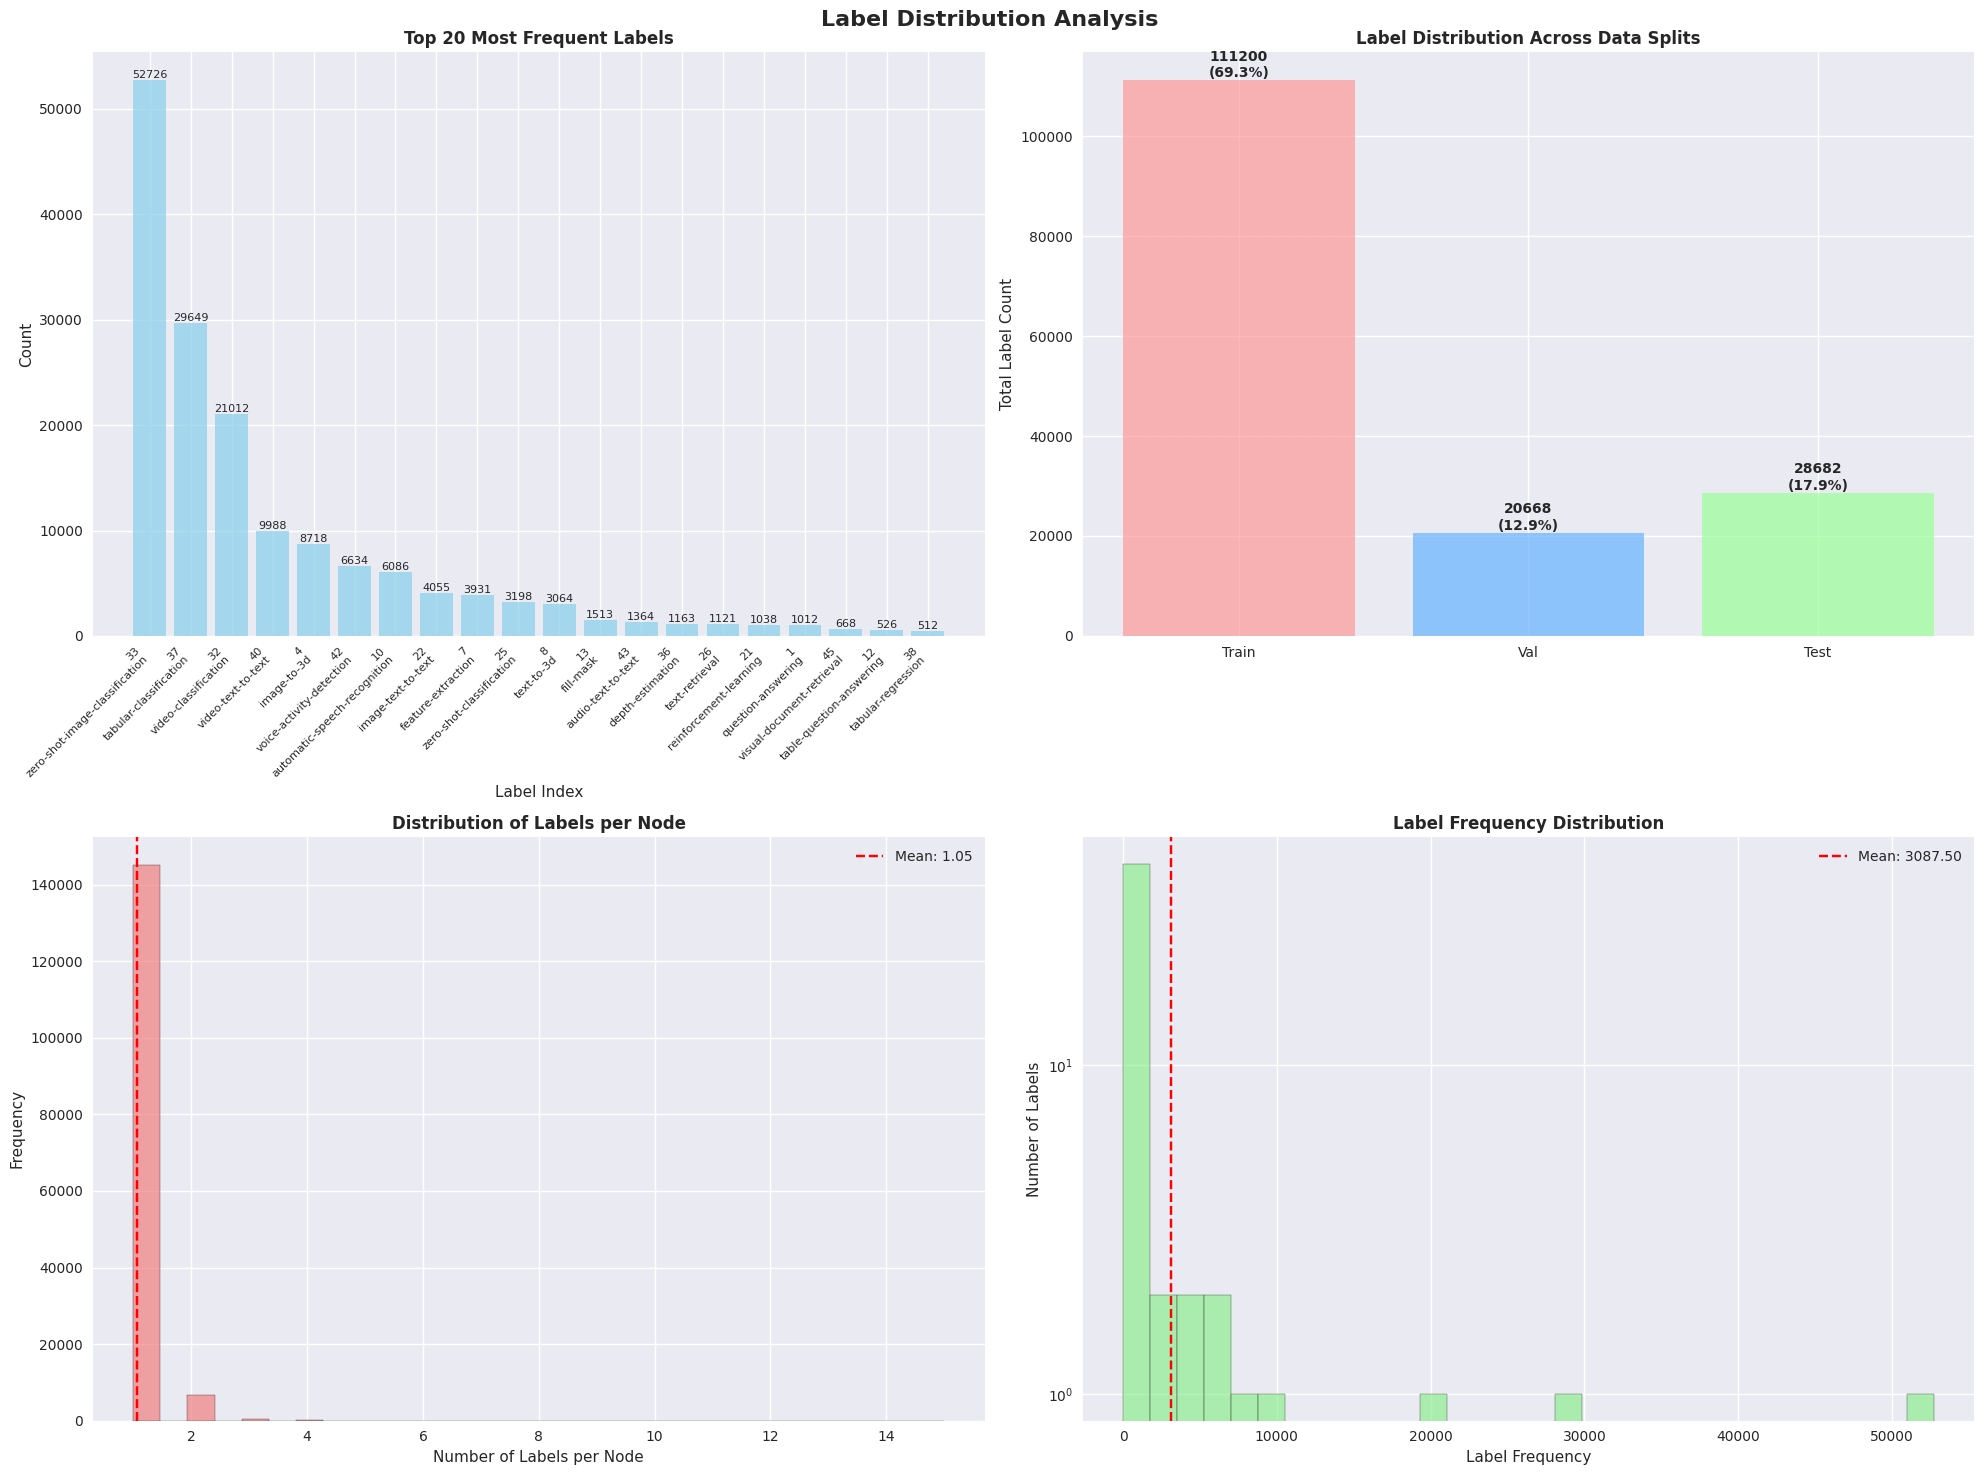


📈 Label Distribution Statistics:
   • Most frequent label: Index 33 with 52726.0 instances
   • Least frequent label: Index 18 with 4.0 instances
   • Labels with 0 instances: 0
   • Standard deviation of label frequencies: 8686.52
   • Coefficient of variation: 2.81


In [20]:
# 2. Label Distribution Visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Label Distribution Analysis', fontsize=16, fontweight='bold')

# Plot 1: Top 20 most frequent labels
ax1 = axes[0, 0]
top_20 = label_df.nlargest(20, 'Total_Count')
bars1 = ax1.bar(range(len(top_20)), top_20['Total_Count'], color='skyblue', alpha=0.7)
ax1.set_title('Top 20 Most Frequent Labels', fontweight='bold')
ax1.set_xlabel('Label Index')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom', fontsize=8)

# Add task names to x-axis if available
if idx_to_task:
    x_labels = [f"{idx}\n{idx_to_task.get(idx, 'Unknown')}" for idx in top_20['Label_Index']]
    ax1.set_xticks(range(len(top_20)))
    ax1.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=8)

# Plot 2: Label distribution across splits
ax2 = axes[0, 1]
splits = ['Train', 'Val', 'Test']
counts = [train_label_counts.sum(), val_label_counts.sum(), test_label_counts.sum()]
colors = ['#ff9999', '#66b3ff', '#99ff99']
bars2 = ax2.bar(splits, counts, color=colors, alpha=0.7)
ax2.set_title('Label Distribution Across Data Splits', fontweight='bold')
ax2.set_ylabel('Total Label Count')

# Add percentage labels
total_count = sum(counts)
for i, (bar, count) in enumerate(zip(bars2, counts)):
    height = bar.get_height()
    percentage = (count / total_count) * 100
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(count)}\n({percentage:.1f}%)', ha='center', va='bottom', fontweight='bold')

# Plot 3: Labels per node distribution
ax3 = axes[1, 0]
labels_per_node = labels.sum(axis=1)
ax3.hist(labels_per_node, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
ax3.set_title('Distribution of Labels per Node', fontweight='bold')
ax3.set_xlabel('Number of Labels per Node')
ax3.set_ylabel('Frequency')
ax3.axvline(labels_per_node.mean(), color='red', linestyle='--', 
           label=f'Mean: {labels_per_node.mean():.2f}')
ax3.legend()

# Plot 4: Label frequency distribution (log scale)
ax4 = axes[1, 1]
ax4.hist(total_labels, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
ax4.set_title('Label Frequency Distribution', fontweight='bold')
ax4.set_xlabel('Label Frequency')
ax4.set_ylabel('Number of Labels')
ax4.set_yscale('log')
ax4.axvline(total_labels.mean(), color='red', linestyle='--', 
           label=f'Mean: {total_labels.mean():.2f}')
ax4.legend()

plt.tight_layout()
plt.show()

# Print additional statistics
print(f"\n📈 Label Distribution Statistics:")
print(f"   • Most frequent label: Index {total_labels.argmax()} with {total_labels.max()} instances")
print(f"   • Least frequent label: Index {total_labels.argmin()} with {total_labels.min()} instances")
print(f"   • Labels with 0 instances: {(total_labels == 0).sum()}")
print(f"   • Standard deviation of label frequencies: {total_labels.std():.2f}")
print(f"   • Coefficient of variation: {total_labels.std() / total_labels.mean():.2f}")


In [21]:
# =============================================================================
# EDA: Sample Graph Visualization
# =============================================================================

print("=" * 60)
print("🕸️ SAMPLE GRAPH VISUALIZATION")
print("=" * 60)

# Convert to NetworkX for visualization (sample a subgraph for performance)
def sample_subgraph(data, sample_size=1000, seed=42):
    """Sample a subgraph for visualization"""
    np.random.seed(seed)
    
    # Get all nodes
    all_nodes = torch.arange(data.num_nodes)
    
    # Sample nodes
    sampled_nodes = torch.from_numpy(np.random.choice(all_nodes.cpu().numpy(), 
                                                    size=min(sample_size, data.num_nodes), 
                                                    replace=False))
    
    # Create node mapping
    node_mapping = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(sampled_nodes)}
    
    # Filter edges that connect sampled nodes
    edge_mask = torch.isin(data.edge_index[0], sampled_nodes) & torch.isin(data.edge_index[1], sampled_nodes)
    filtered_edges = data.edge_index[:, edge_mask]
    
    # Remap edge indices to new node indices
    new_edge_index = torch.zeros_like(filtered_edges)
    for i in range(filtered_edges.shape[1]):
        new_edge_index[0, i] = node_mapping[filtered_edges[0, i].item()]
        new_edge_index[1, i] = node_mapping[filtered_edges[1, i].item()]
    
    # Create subgraph data
    subgraph = Data(
        x=data.x[sampled_nodes],
        edge_index=new_edge_index,
        y=data.y[sampled_nodes],
        train_mask=data.train_mask[sampled_nodes],
        val_mask=data.val_mask[sampled_nodes],
        test_mask=data.test_mask[sampled_nodes]
    )
    
    return subgraph, sampled_nodes

# Sample a subgraph for visualization
subgraph, sampled_node_indices = sample_subgraph(data, sample_size=500)
print(f"Sampled subgraph: {subgraph.num_nodes} nodes, {subgraph.num_edges} edges")

# Convert to NetworkX
G = to_networkx(subgraph, to_undirected=True)
print(f"NetworkX graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Calculate basic graph statistics
print(f"\n📊 Graph Statistics:")
print(f"   • Number of connected components: {nx.number_connected_components(G)}")
print(f"   • Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
print(f"   • Density: {nx.density(G):.4f}")
print(f"   • Average clustering coefficient: {nx.average_clustering(G):.4f}")

# Get the largest connected component for better visualization
largest_cc = max(nx.connected_components(G), key=len)
G_largest = G.subgraph(largest_cc)
print(f"   • Largest connected component: {G_largest.number_of_nodes()} nodes, {G_largest.number_of_edges()} edges")


🕸️ SAMPLE GRAPH VISUALIZATION
Sampled subgraph: 500 nodes, 2 edges
NetworkX graph: 500 nodes, 2 edges

📊 Graph Statistics:
   • Number of connected components: 499
   • Average degree: 0.01
   • Density: 0.0000
   • Average clustering coefficient: 0.0000
   • Largest connected component: 2 nodes, 1 edges


In [22]:
data.edge_index

tensor([[  8971,   8971,   8971,  ...,  39460,  57835,   2206],
        [ 97862,  11921, 148534,  ...,  92090,  92090,  92090]])

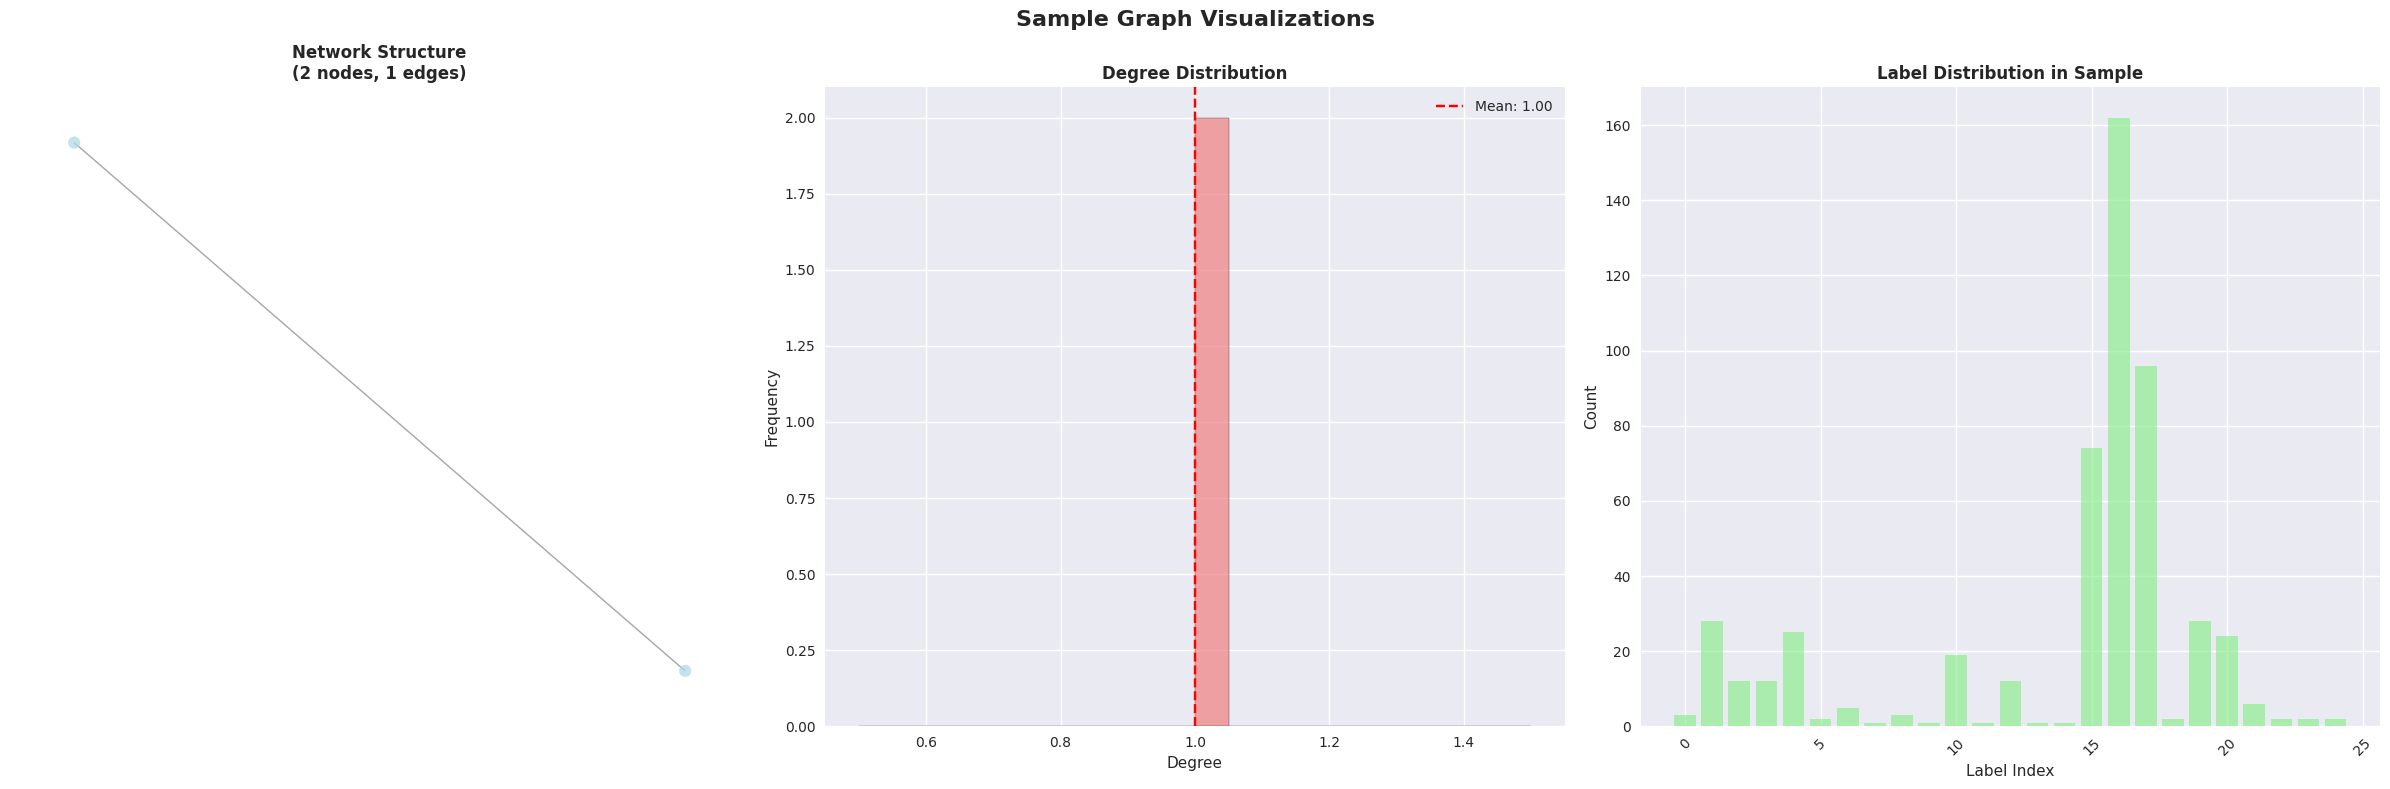


🔍 Detailed Graph Metrics:
   • Diameter: 1
   • Radius: 1
   • Average shortest path length: 1.0
   • Assortativity coefficient: nan

📈 Node Degree Statistics:
   • Max degree: 1
   • Min degree: 1
   • Median degree: 1.00
   • Standard deviation: 0.00


In [23]:
# Visualize the largest connected component
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('Sample Graph Visualizations', fontsize=16, fontweight='bold')

# Plot 1: Network visualization with degree-based node sizes
ax1 = axes[0]
pos = nx.spring_layout(G_largest, k=1, iterations=50, seed=42)
degrees = dict(G_largest.degree())
node_sizes = [degrees[node] * 20 + 50 for node in G_largest.nodes()]

nx.draw(G_largest, pos, 
        node_size=node_sizes,
        node_color='lightblue',
        edge_color='gray',
        alpha=0.7,
        with_labels=False,
        ax=ax1)
ax1.set_title(f'Network Structure\n({G_largest.number_of_nodes()} nodes, {G_largest.number_of_edges()} edges)', 
              fontweight='bold')

# Plot 2: Degree distribution
ax2 = axes[1]
degree_sequence = sorted([d for n, d in G_largest.degree()], reverse=True)
ax2.hist(degree_sequence, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
ax2.set_title('Degree Distribution', fontweight='bold')
ax2.set_xlabel('Degree')
ax2.set_ylabel('Frequency')
ax2.axvline(np.mean(degree_sequence), color='red', linestyle='--', 
           label=f'Mean: {np.mean(degree_sequence):.2f}')
ax2.legend()

# Plot 3: Node label distribution in the sample
ax3 = axes[2]
sample_labels = subgraph.y.cpu().numpy()
sample_label_counts = sample_labels.sum(axis=0)
non_zero_labels = sample_label_counts[sample_label_counts > 0]

ax3.bar(range(len(non_zero_labels)), non_zero_labels, alpha=0.7, color='lightgreen')
ax3.set_title('Label Distribution in Sample', fontweight='bold')
ax3.set_xlabel('Label Index')
ax3.set_ylabel('Count')
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Additional graph metrics
print(f"\n🔍 Detailed Graph Metrics:")
print(f"   • Diameter: {nx.diameter(G_largest) if nx.is_connected(G_largest) else 'N/A (disconnected)'}")
print(f"   • Radius: {nx.radius(G_largest) if nx.is_connected(G_largest) else 'N/A (disconnected)'}")
print(f"   • Average shortest path length: {nx.average_shortest_path_length(G_largest) if nx.is_connected(G_largest) else 'N/A (disconnected)'}")
print(f"   • Assortativity coefficient: {nx.degree_assortativity_coefficient(G_largest):.4f}")

# Node degree statistics
print(f"\n📈 Node Degree Statistics:")
print(f"   • Max degree: {max(degree_sequence)}")
print(f"   • Min degree: {min(degree_sequence)}")
print(f"   • Median degree: {np.median(degree_sequence):.2f}")
print(f"   • Standard deviation: {np.std(degree_sequence):.2f}")


🔬 NODE FEATURE ANALYSIS
Feature matrix shape: (152435, 768)
Feature data type: float32
Feature value range: [-0.3445, 0.1637]

📊 Feature Statistics:
   • Mean of feature means: -0.0006
   • Mean of feature stds: 0.0171
   • Features with zero variance: 0
   • Features with near-zero variance (< 0.001): 0


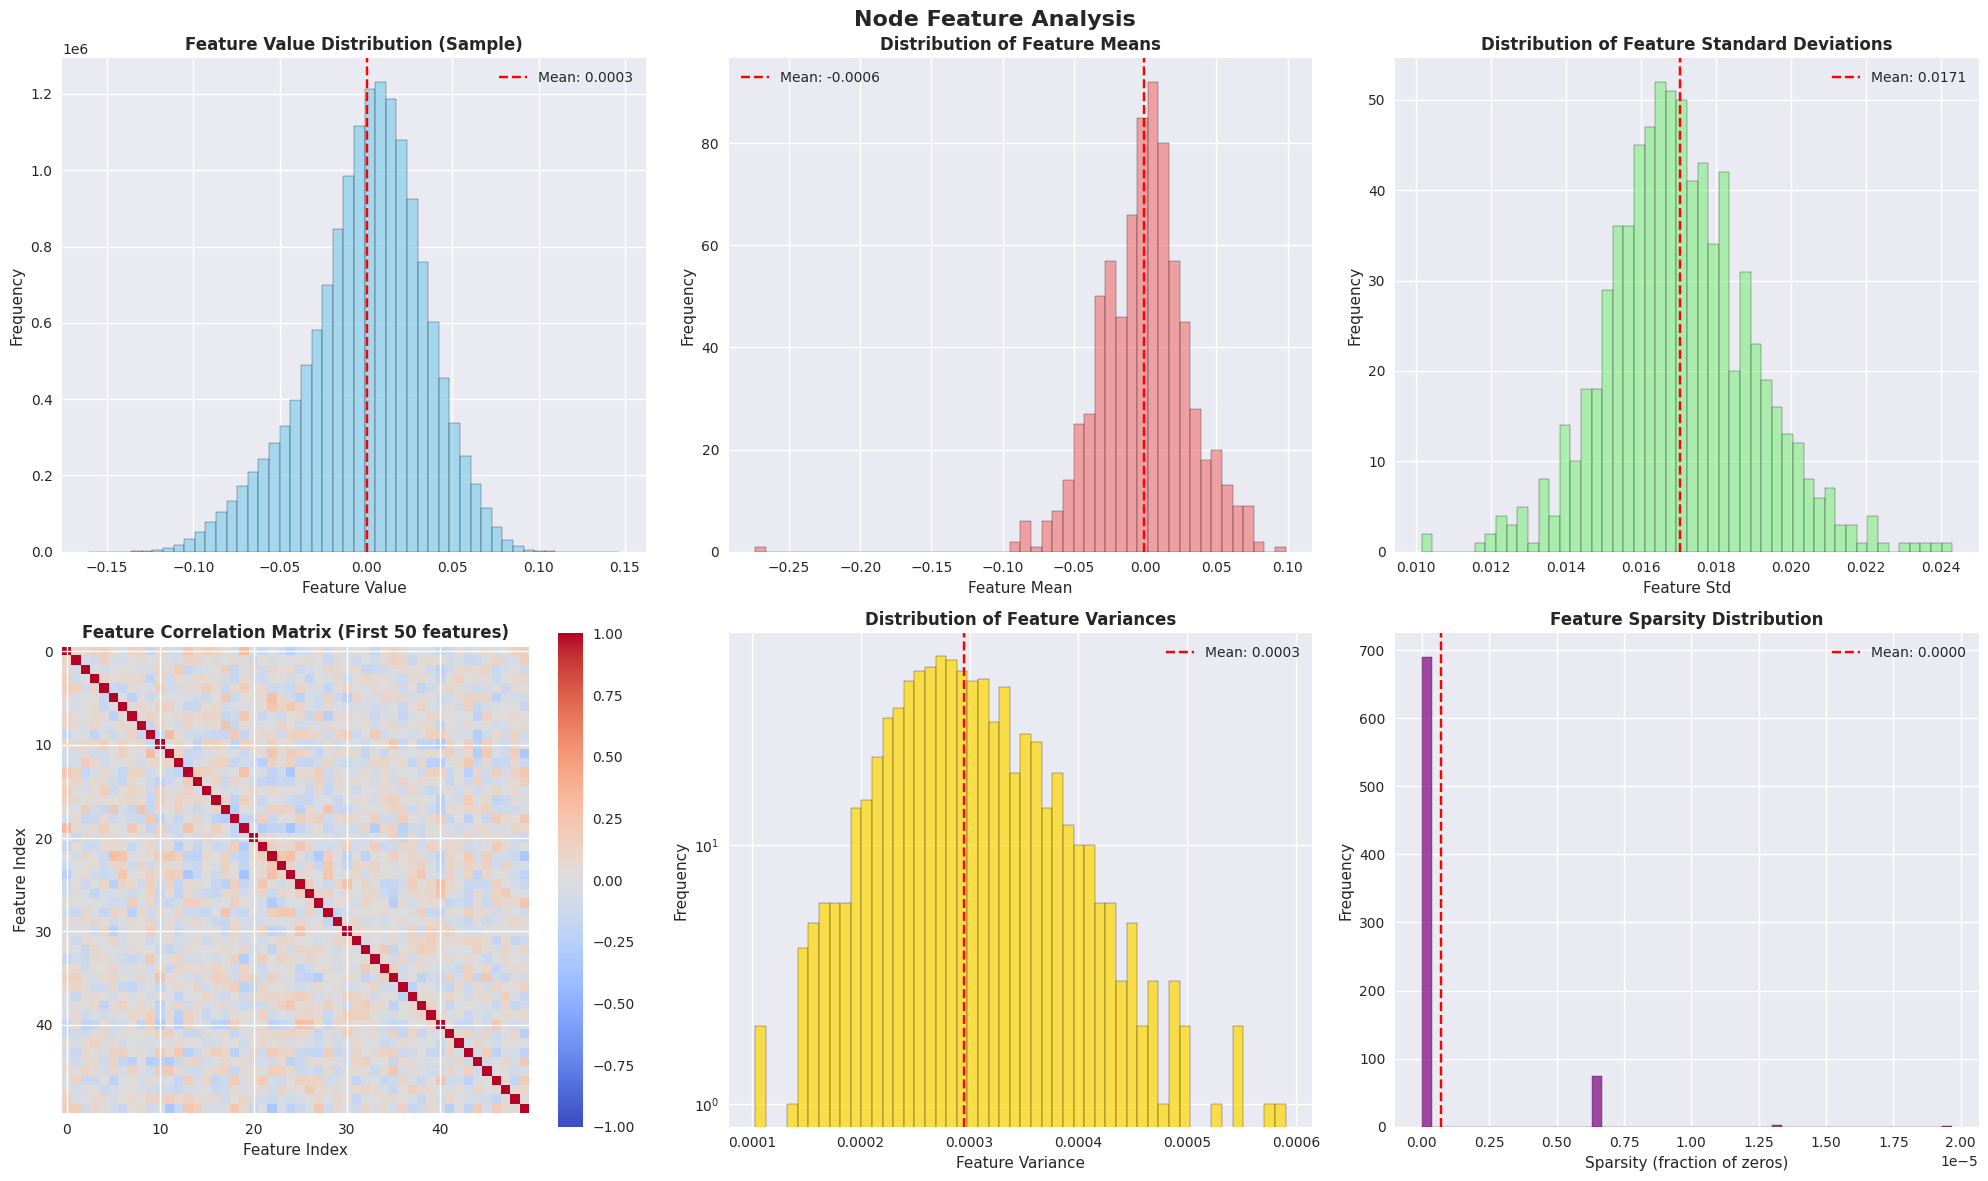


🔍 Feature Quality Metrics:
   • Features with high sparsity (>90% zeros): 0
   • Features with low sparsity (<10% zeros): 768
   • Average feature sparsity: 0.0000
   • Features with extreme values (>3 std from mean): 18364054


In [24]:
# =============================================================================
# EDA: Node Feature Analysis
# =============================================================================

print("=" * 60)
print("🔬 NODE FEATURE ANALYSIS")
print("=" * 60)

# Convert features to numpy for analysis
features = data.x.cpu().numpy()
print(f"Feature matrix shape: {features.shape}")
print(f"Feature data type: {features.dtype}")
print(f"Feature value range: [{features.min():.4f}, {features.max():.4f}]")

# Basic feature statistics
feature_means = np.mean(features, axis=0)
feature_stds = np.std(features, axis=0)
feature_medians = np.median(features, axis=0)

print(f"\n📊 Feature Statistics:")
print(f"   • Mean of feature means: {np.mean(feature_means):.4f}")
print(f"   • Mean of feature stds: {np.mean(feature_stds):.4f}")
print(f"   • Features with zero variance: {(feature_stds == 0).sum()}")
print(f"   • Features with near-zero variance (< 0.001): {(feature_stds < 0.001).sum()}")

# Feature distribution analysis
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Node Feature Analysis', fontsize=16, fontweight='bold')

# Plot 1: Feature value distribution (sample of features)
ax1 = axes[0, 0]
sample_features = features[:, :min(100, features.shape[1])]  # Sample first 100 features
ax1.hist(sample_features.flatten(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('Feature Value Distribution (Sample)', fontweight='bold')
ax1.set_xlabel('Feature Value')
ax1.set_ylabel('Frequency')
ax1.axvline(sample_features.mean(), color='red', linestyle='--', 
           label=f'Mean: {sample_features.mean():.4f}')
ax1.legend()

# Plot 2: Feature means distribution
ax2 = axes[0, 1]
ax2.hist(feature_means, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
ax2.set_title('Distribution of Feature Means', fontweight='bold')
ax2.set_xlabel('Feature Mean')
ax2.set_ylabel('Frequency')
ax2.axvline(np.mean(feature_means), color='red', linestyle='--', 
           label=f'Mean: {np.mean(feature_means):.4f}')
ax2.legend()

# Plot 3: Feature standard deviations distribution
ax3 = axes[0, 2]
ax3.hist(feature_stds, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
ax3.set_title('Distribution of Feature Standard Deviations', fontweight='bold')
ax3.set_xlabel('Feature Std')
ax3.set_ylabel('Frequency')
ax3.axvline(np.mean(feature_stds), color='red', linestyle='--', 
           label=f'Mean: {np.mean(feature_stds):.4f}')
ax3.legend()

# Plot 4: Feature correlation heatmap (sample)
ax4 = axes[1, 0]
sample_size = min(50, features.shape[1])
sample_features_corr = features[:, :sample_size]
correlation_matrix = np.corrcoef(sample_features_corr.T)
im = ax4.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
ax4.set_title(f'Feature Correlation Matrix (First {sample_size} features)', fontweight='bold')
ax4.set_xlabel('Feature Index')
ax4.set_ylabel('Feature Index')
plt.colorbar(im, ax=ax4)

# Plot 5: Feature variance distribution
ax5 = axes[1, 1]
feature_vars = np.var(features, axis=0)
ax5.hist(feature_vars, bins=50, alpha=0.7, color='gold', edgecolor='black')
ax5.set_title('Distribution of Feature Variances', fontweight='bold')
ax5.set_xlabel('Feature Variance')
ax5.set_ylabel('Frequency')
ax5.set_yscale('log')
ax5.axvline(np.mean(feature_vars), color='red', linestyle='--', 
           label=f'Mean: {np.mean(feature_vars):.4f}')
ax5.legend()

# Plot 6: Feature sparsity
ax6 = axes[1, 2]
feature_sparsity = (features == 0).sum(axis=0) / features.shape[0]
ax6.hist(feature_sparsity, bins=50, alpha=0.7, color='purple', edgecolor='black')
ax6.set_title('Feature Sparsity Distribution', fontweight='bold')
ax6.set_xlabel('Sparsity (fraction of zeros)')
ax6.set_ylabel('Frequency')
ax6.axvline(np.mean(feature_sparsity), color='red', linestyle='--', 
           label=f'Mean: {np.mean(feature_sparsity):.4f}')
ax6.legend()

plt.tight_layout()
plt.show()

# Additional feature analysis
print(f"\n🔍 Feature Quality Metrics:")
print(f"   • Features with high sparsity (>90% zeros): {(feature_sparsity > 0.9).sum()}")
print(f"   • Features with low sparsity (<10% zeros): {(feature_sparsity < 0.1).sum()}")
print(f"   • Average feature sparsity: {np.mean(feature_sparsity):.4f}")
print(f"   • Features with extreme values (>3 std from mean): {np.sum(np.abs(features) > 3 * feature_stds)}")


In [25]:
# =============================================================================
# EDA: Edge Analysis and Graph Connectivity
# =============================================================================

print("=" * 60)
print("🔗 EDGE ANALYSIS & GRAPH CONNECTIVITY")
print("=" * 60)

# Edge analysis
edge_index = data.edge_index.cpu().numpy()
print(f"Edge index shape: {edge_index.shape}")
print(f"Number of edges: {edge_index.shape[1]}")
print(f"Edge index dtype: {edge_index.dtype}")

# Check for self-loops and duplicate edges
source_nodes = edge_index[0]
target_nodes = edge_index[1]

self_loops = (source_nodes == target_nodes).sum()
print(f"Number of self-loops: {self_loops}")

# Check for duplicate edges (considering both directions)
edges_set = set()
duplicate_edges = 0
for i in range(edge_index.shape[1]):
    edge = tuple(sorted([source_nodes[i], target_nodes[i]]))
    if edge in edges_set:
        duplicate_edges += 1
    else:
        edges_set.add(edge)

print(f"Number of duplicate edges: {duplicate_edges}")

# Graph connectivity analysis
print(f"\n📊 Graph Connectivity Analysis:")
print(f"   • Total nodes: {data.num_nodes}")
print(f"   • Total edges: {data.num_edges}")
print(f"   • Graph density: {2 * data.num_edges / (data.num_nodes * (data.num_nodes - 1)):.6f}")
print(f"   • Average degree: {2 * data.num_edges / data.num_nodes:.2f}")

# Analyze degree distribution
degrees = np.zeros(data.num_nodes)
for i in range(edge_index.shape[1]):
    degrees[source_nodes[i]] += 1
    degrees[target_nodes[i]] += 1

print(f"   • Max degree: {degrees.max()}")
print(f"   • Min degree: {degrees.min()}")
print(f"   • Mean degree: {degrees.mean():.2f}")
print(f"   • Median degree: {np.median(degrees):.2f}")
print(f"   • Std degree: {degrees.std():.2f}")

# Analyze isolated nodes
isolated_nodes = (degrees == 0).sum()
print(f"   • Isolated nodes (degree 0): {isolated_nodes} ({isolated_nodes/data.num_nodes*100:.2f}%)")

# Analyze high-degree nodes
high_degree_threshold = np.percentile(degrees, 95)
high_degree_nodes = (degrees >= high_degree_threshold).sum()
print(f"   • High-degree nodes (≥95th percentile): {high_degree_nodes} ({high_degree_nodes/data.num_nodes*100:.2f}%)")


🔗 EDGE ANALYSIS & GRAPH CONNECTIVITY
Edge index shape: (2, 166199)
Number of edges: 166199
Edge index dtype: int64
Number of self-loops: 786
Number of duplicate edges: 293

📊 Graph Connectivity Analysis:
   • Total nodes: 152435
   • Total edges: 166199
   • Graph density: 0.000014
   • Average degree: 2.18
   • Max degree: 11524.0
   • Min degree: 1.0
   • Mean degree: 2.18
   • Median degree: 1.00
   • Std degree: 41.23
   • Isolated nodes (degree 0): 0 (0.00%)
   • High-degree nodes (≥95th percentile): 7842 (5.14%)


In [26]:
# =============================================================================
# EDA: Summary and Key Insights
# =============================================================================

print("=" * 60)
print("📋 EDA SUMMARY & KEY INSIGHTS")
print("=" * 60)

print("🎯 Dataset Overview:")
print(f"   • Total nodes: {data.num_nodes:,}")
print(f"   • Total edges: {data.num_edges:,}")
print(f"   • Feature dimension: {data.x.shape[1]}")
print(f"   • Number of labels: {data.y.shape[1]}")
print(f"   • Graph density: {2 * data.num_edges / (data.num_nodes * (data.num_nodes - 1)):.6f}")

print(f"\n🏷️ Label Analysis:")
print(f"   • Total label instances: {total_labels.sum():,}")
print(f"   • Average labels per node: {total_labels.sum() / data.num_nodes:.2f}")
most_freq_idx = total_labels.argmax()
most_freq_name = idx_to_task.get(most_freq_idx, f"Index {most_freq_idx}")
print(f"   • Most frequent label: {most_freq_name} ({total_labels.max()} instances)")
print(f"   • Labels with zero instances: {(total_labels == 0).sum()}")
print(f"   • Label distribution CV: {total_labels.std() / total_labels.mean():.2f}")

# Show top 5 task categories
if idx_to_task:
    print(f"\n📊 Top 5 Task Categories:")
    top_5_tasks = label_df.nlargest(5, 'Total_Count')
    for _, row in top_5_tasks.iterrows():
        task_name = idx_to_task.get(row['Label_Index'], f"Index {row['Label_Index']}")
        print(f"   • {task_name}: {row['Total_Count']} instances ({row['Total_Percentage']:.1f}%)")

print(f"\n🔗 Graph Structure:")
print(f"   • Average degree: {degrees.mean():.2f}")
print(f"   • Max degree: {degrees.max()}")
print(f"   • Isolated nodes: {isolated_nodes} ({isolated_nodes/data.num_nodes*100:.2f}%)")
print(f"   • Self-loops: {self_loops}")
print(f"   • Duplicate edges: {duplicate_edges}")

print(f"\n🔬 Feature Quality:")
print(f"   • Feature value range: [{features.min():.4f}, {features.max():.4f}]")
print(f"   • Average feature sparsity: {np.mean(feature_sparsity):.4f}")
print(f"   • Features with zero variance: {(feature_stds == 0).sum()}")
print(f"   • High sparsity features (>90% zeros): {(feature_sparsity > 0.9).sum()}")

print(f"\n📊 Data Splits:")
print(f"   • Train nodes: {data.train_mask.sum():,} ({data.train_mask.sum()/data.num_nodes*100:.1f}%)")
print(f"   • Val nodes: {data.val_mask.sum():,} ({data.val_mask.sum()/data.num_nodes*100:.1f}%)")
print(f"   • Test nodes: {data.test_mask.sum():,} ({data.test_mask.sum()/data.num_nodes*100:.1f}%)")

print(f"\n💡 Key Insights:")
print(f"   • This is a {data.num_nodes:,}-node graph with {data.num_edges:,} edges")
print(f"   • The graph is {'sparse' if 2 * data.num_edges / (data.num_nodes * (data.num_nodes - 1)) < 0.01 else 'dense'}")
print(f"   • Label distribution is {'balanced' if total_labels.std() / total_labels.mean() < 1.0 else 'imbalanced'}")
print(f"   • Node connectivity shows {'high' if degrees.mean() > 10 else 'low'} average degree")
print(f"   • Feature quality is {'good' if (feature_stds == 0).sum() < 10 else 'needs attention'}")

print(f"\n✅ EDA Analysis Complete!")
print("=" * 60)


📋 EDA SUMMARY & KEY INSIGHTS
🎯 Dataset Overview:
   • Total nodes: 152,435
   • Total edges: 166,199
   • Feature dimension: 768
   • Number of labels: 52
   • Graph density: 0.000014

🏷️ Label Analysis:
   • Total label instances: 160,550.0
   • Average labels per node: 1.05
   • Most frequent label: zero-shot-image-classification (52726.0 instances)
   • Labels with zero instances: 0
   • Label distribution CV: 2.81

📊 Top 5 Task Categories:
   • zero-shot-image-classification: 52726.0 instances (32.8%)
   • tabular-classification: 29649.0 instances (18.5%)
   • video-classification: 21012.0 instances (13.1%)
   • video-text-to-text: 9988.0 instances (6.2%)
   • image-to-3d: 8718.0 instances (5.4%)

🔗 Graph Structure:
   • Average degree: 2.18
   • Max degree: 11524.0
   • Isolated nodes: 0 (0.00%)
   • Self-loops: 786
   • Duplicate edges: 293

🔬 Feature Quality:
   • Feature value range: [-0.3445, 0.1637]
   • Average feature sparsity: 0.0000
   • Features with zero variance: 0
   